In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

#Model

In [2]:
class MLP(nn.Module):
  def __init__(self):
    super().__init__()

    self.net = nn.Sequential(
        nn.Linear(2,128),
        nn.Tanh(),
        nn.Linear(128,128),
        nn.Tanh(),
        nn.Linear(128,1)
    )

  def forward(self,x):
    return self.net(x)

#Training Loop

In [3]:
def hamiltonian_dynamics(model, x):
  x = x.clone().detach().requires_grad_(True)

  H = model(x).sum()

  grad = torch.autograd.grad(
      H,
      x,
      create_graph=True
  )[0]

  d_theta = grad[:,1]
  d_omega = -grad[:,0]

  return torch.stack([d_theta, d_omega], dim=1)

In [4]:
#-------------
# Load data
#-------------

data = np.load("2.1_HNN.npz")
split = np.load("2.2_HNN.npz")

X = np.hstack(data["X"])
X = data["X"].reshape(10000, 2)
Y = data["Y"]
Y = data["Y"].reshape(10000, 2)
print(X.shape)

#---------------
# Normalization
#---------------

X_mean = X.mean()
X_std  = X.std()

Y_mean = Y.mean()
Y_std  = Y.std()

X = (X - X_mean) / X_std
Y = (Y - Y_mean) / Y_std


X_train = X[split["train_idx"]]
Y_train = Y[split["train_idx"]]

X_test = X[split["test_idx"]]
Y_test = Y[split["test_idx"]]

#-------------------
# Convert to tensor
#-------------------

X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32)

X_test = torch.tensor(X_test, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train, Y_train)
test_dataset = TensorDataset(X_test, Y_test)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

#---------
#  Model
#---------

model = MLP()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

#----------------
# Training loop
#----------------

n_epochs = 500

for epoch in range(n_epochs):
  model.train()
  train_loss = 0.0

  for X_batch, Y_batch in train_loader:
    Y_pred = hamiltonian_dynamics(model, X_batch)
    loss = loss_fn(Y_pred, Y_batch)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

  train_loss /= len(train_loader)


  model.eval()
  test_loss = 0.0

  for X_batch, Y_batch in test_loader:
      Y_pred = hamiltonian_dynamics(model, X_batch)
      loss = loss_fn(Y_pred, Y_batch)
      test_loss += loss.item()

  test_loss /= len(test_loader)
  print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

#-------------
# Save model
#-------------

torch.save(model.state_dict(), "HNN_rk4.pth")

(10000, 2)
Epoch 1/500, Train Loss: 0.7430, Test Loss: 1.3739
Epoch 2/500, Train Loss: 0.6817, Test Loss: 1.3269
Epoch 3/500, Train Loss: 0.6119, Test Loss: 1.0168
Epoch 4/500, Train Loss: 0.4013, Test Loss: 0.4832
Epoch 5/500, Train Loss: 0.2491, Test Loss: 0.2986
Epoch 6/500, Train Loss: 0.1670, Test Loss: 0.2543
Epoch 7/500, Train Loss: 0.1283, Test Loss: 0.1979
Epoch 8/500, Train Loss: 0.1173, Test Loss: 0.0806
Epoch 9/500, Train Loss: 0.1034, Test Loss: 0.0369
Epoch 10/500, Train Loss: 0.0975, Test Loss: 0.0240
Epoch 11/500, Train Loss: 0.0963, Test Loss: 0.0256
Epoch 12/500, Train Loss: 0.0941, Test Loss: 0.0191
Epoch 13/500, Train Loss: 0.0896, Test Loss: 0.0150
Epoch 14/500, Train Loss: 0.0884, Test Loss: 0.0161
Epoch 15/500, Train Loss: 0.0820, Test Loss: 0.0178
Epoch 16/500, Train Loss: 0.0802, Test Loss: 0.0194
Epoch 17/500, Train Loss: 0.0778, Test Loss: 0.0220
Epoch 18/500, Train Loss: 0.0784, Test Loss: 0.0212
Epoch 19/500, Train Loss: 0.0769, Test Loss: 0.0193
Epoch 20/5

#Test

In [12]:
def pendulum_dynamics(x, u, params):  # Compute the function f(x,t) such that theta'' = f(x,t)
  theta, omega = x
  m, l, g = params["m"], params["l"], params["g"]
  u = float(u)

  d_theta = omega
  d_omega = (g/l) * np.sin(theta) + u/(m * l**2)

  return np.array([d_theta, d_omega])

def hamiltonian_dynamics_norm(model, x): # compute x' using the HNN, x muste be shape (2,)
  x_n = (x - X_mean)/X_std
  x_n = x_n.clone().detach().requires_grad_(True)
  H_n = model(x_n).sum()

  grad_Hn = torch.autograd.grad(
      H_n,
      x_n,
      create_graph=True
  )[0]

  grad_H = grad_Hn / X_std
  d_theta = grad_H[1]
  d_omega = -grad_H[0]

  return torch.stack([d_theta, d_omega], dim=0)



def rk4_step_HNN(f, x, dt):   # rk4_step but adapted for the HNN
    k1 = hamiltonian_dynamics_norm(f, x)
    k2 = hamiltonian_dynamics_norm(f, x + 0.5 * dt * k1)
    k3 = hamiltonian_dynamics_norm(f, x + 0.5 * dt * k2)
    k4 = hamiltonian_dynamics_norm(f, x + dt * k3)
    return x + (dt/6)*(k1 + 2*k2 + 2*k3 + k4)


def rk4_step(f, x, u, dt, params):  # Compute the position after a short time dt based on the pervious position using rk4 method
  k1 = f(x, u, params)
  k2 = f(x + 0.5 * dt * k1, u, params)
  k3 = f(x + 0.5 * dt * k2, u, params)
  k4 = f(x + dt * k3, u, params)

  return x + (dt/6)*(k1 + 2*k2 + 2*k3 + k4)

def trajectory_simulation(x0, u_control, dt, T, params):  # Compute the trajectory using rk4_step at each step
  N = int(T/dt)
  x = np.zeros((N+1, 2))
  x[0] = x0
  E = np.zeros(N+1)
  E[0] = (1/2)*(x0[1]**2) + (1 - np.cos(x0[0]))
  for t in range(N):
    u = u_control(t * dt, x[t])
    x[t+1] = rk4_step(pendulum_dynamics, x[t], u, dt, params)
    E[t+1] = (1/2)*(x[t+1,1]**2) + (1 - np.cos(x[t+1,0]))
  return x, E

def trajectory_simulation_HNN(x0, dt, T):  # adapted version for the HNN
    N = int(T / dt)
    x = torch.zeros((N+1, 2))
    x[0] = torch.tensor(x0, dtype=torch.float32)
    E = np.zeros(N+1)
    E[0] = (1/2)*(x0[1]**2) + (1 - np.cos(x0[0]))

    for t in range(N):
        x[t+1] = rk4_step_HNN(model, x[t], dt).detach()
        E[t+1] = (1/2)*(x[t+1,1]**2) + (1 - np.cos(x[t+1,0]))

    return x.detach().numpy(), E


def zero_control(t,x):
  return 0

def dH_dt(model, x):
    x = x.clone().detach().requires_grad_(True)
    dx = hamiltonian_dynamics_norm(model, x)

    H = model((x - X_mean) / X_std).sum()
    grad_H = torch.autograd.grad(H, x)[0]

    return torch.dot(grad_H, dx)


/tmp/ipython-input-410506764.py:67: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  E[t+1] = (1/2)*(x[t+1,1]**2) + (1 - np.cos(x[t+1,0]))


tensor(0., grad_fn=<DotBackward0>)
(2001, 2)
(2001, 2)
(2001,)


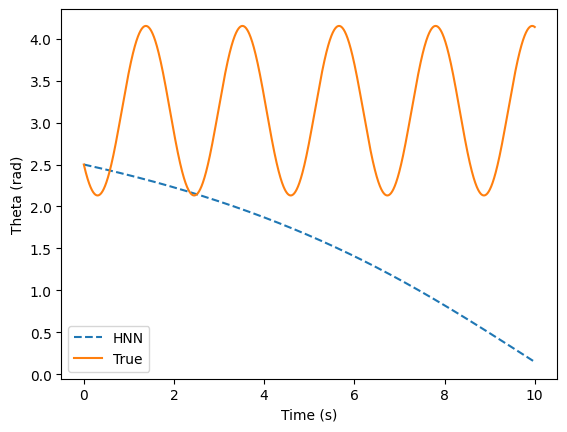

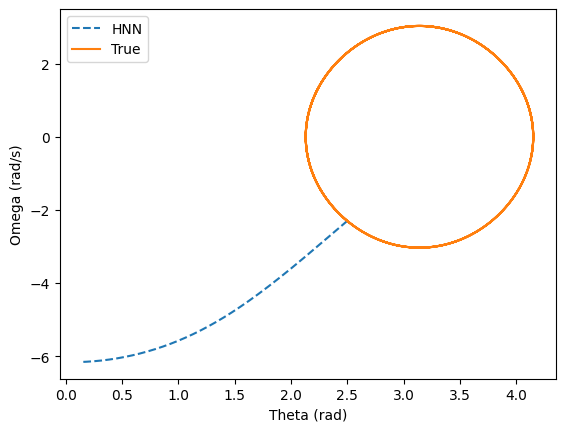

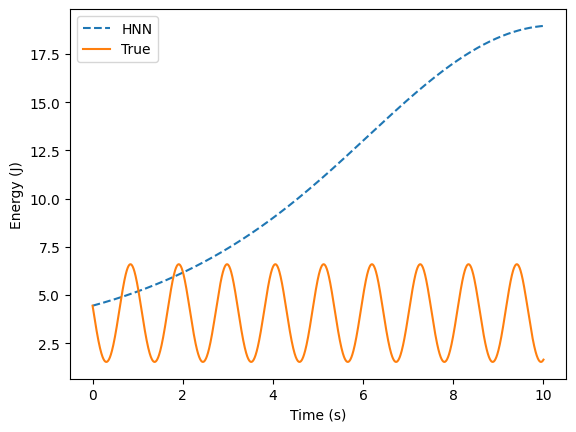

In [14]:
#--------------
# Parameters
#--------------

params = {
    "g": 9.81,   # gravity (m/s^2)
    "l": 1.0,    # lenght (m)
    "m": 1.0     # mass (kg)
}

x0 = [2.5,-2.3]
HNN_trajectory = []
true_trajectory = []
T = 10.0 # 10s
dt = 0.005 # 2000 step

#--------------
# Trajectories
#--------------

HNN_trajectory, E_HNN = trajectory_simulation_HNN(x0, dt, T)

true_trajectory, E_true = trajectory_simulation(x0, zero_control, T=10.0, dt=0.005, params=params)

print( dH_dt(model, torch.tensor(x0, dtype=torch.float32)))

#-------
# Plot
#-------

t = np.arange(start = 0, stop = 10.004, step = dt)

print(HNN_trajectory.shape)
print(true_trajectory.shape)
print(t.shape)

plt.plot(t, np.array(HNN_trajectory)[:,0], "--")
plt.plot(t, np.array(true_trajectory)[:,0])
plt.xlabel("Time (s)")
plt.ylabel("Theta (rad)")
plt.legend(["HNN", "True"])
plt.show()

plt.figure()
plt.plot(np.array(HNN_trajectory)[:,0], np.array(HNN_trajectory)[:,1], "--")
plt.plot(np.array(true_trajectory)[:,0], np.array(true_trajectory)[:,1])
plt.legend(["HNN", "True"])
plt.xlabel("Theta (rad)")
plt.ylabel("Omega (rad/s)")
plt.show()

plt.figure()
plt.plot(t, E_HNN, "--")
plt.plot(t, E_true)
plt.legend(["HNN", "True"])
plt.xlabel("Time (s)")
plt.ylabel("Energy (J)")
plt.show()
